In [1]:
A = ''
B = A[:0]+'a'+A[0:]
B, len(B)

('a', 1)

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choices 

import operators as Operators
from metaheuristic import Metaheuristic
import benchmark_func as bf
from hyperheuristic import Hyperheuristic, _save_step
from neural_network import ModelPredictorTransformerOriginal, DatasetSequences
from encode_operators import compress_operator, decompress_operator

import torch
from transformers import PreTrainedTokenizerFast, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import load_metric as load_metric_hf 
from datasets import Dataset as Dataset_hf

from timeit import default_timer as timer

In [5]:
limit_seq = 100

seqs, costs = [], []
for counting in range(1, 11):
  with open(f'vocabulary/seq_read_{counting}.txt', 'r', encoding='utf-8') as file:
    seqs = seqs + file.read().split('\n')  
  with open(f'vocabulary/score_{counting}.txt', 'r', encoding='utf-8') as file:
    costs = costs + file.read().split('\n')
    

In [6]:
# Read operators and find their alias
collections = ['default.txt', 'basicmetaheuristics.txt']

encoded_heuristic_space = dict()
operators_string = dict()
for collection_file in collections:
    with open('./collections/' + collection_file, 'r') as operators_file:
        operators_string[collection_file] = [line.rstrip('\n') for line in operators_file]
        encoded_heuristic_space[collection_file] = [eval(line) for line in operators_string[collection_file]]

In [7]:
def parse_sequence(seq):
  operators = []
  prev_idx = 0
  counting = 0
  for i, c in enumerate(seq):
    if c == '(':
      counting += 1
    if c == ')':
      counting -= 1
      if counting == 0:
        operators.append(seq[prev_idx:i+1])
        prev_idx = i + 3
  return operators

def get_ids_operators(operators):
  ids = []
  for operator in operators:
    ids_bool = np.array(operators_string['default.txt']) == operator
    ids.append(np.where(ids_bool)[0][0])
  return ids

def generate_seqs():
  seqs_operators = []
  seqs_ids = []
  for seq in seqs:
    operators = parse_sequence(seq)
    seq_ids = get_ids_operators(operators)
    seqs_operators.append(operators)
    seqs_ids.append(seq_ids)
  fitnesses = [eval(cost) for cost in costs]
  return seqs_operators, seqs_ids, fitnesses

      
seqs_operators, seqs_ids, fitnesses = generate_seqs()

In [2]:
from tools import read_json

In [3]:
exp_names = ["hybertheuristic-tests"+case for case in ['', '-2', '-3']] + \
  ['HyGpt-tests'+case for case in [''] + ['-'+str(x) for x in range(2, 10)]] + \
    ['HyGpt-compress-tests']

In [16]:
fitness_good = []
last_fitness = lambda w: [x[-1] for x in w]

for exp_name in exp_names:
  A = read_json('transformer_experiments/'+exp_name+'.json')
  print(A['results'][0]['performance'], exp_name)
  z = last_fitness(A['results'][0]['hist_fitness'])
  fitness_good.append(z)

2.224543865243707 hybertheuristic-tests
8.264913471550377 hybertheuristic-tests-2
1.4058307931802463 hybertheuristic-tests-3
2.6446830772413845 HyGpt-tests
3.128178734375081 HyGpt-tests-2
16.84515015458498 HyGpt-tests-3
11.310470983468345 HyGpt-tests-4
11.77951407856105 HyGpt-tests-5
6.863995018424299 HyGpt-tests-6
12.429074131689797 HyGpt-tests-7
9.711034792817905 HyGpt-tests-8
24.30262993279646 HyGpt-tests-9
4.891829972022509 HyGpt-compress-tests


1.25 0.2550296223972298
2.25 0.42249062771929696
3.25 0.11208444287084729
4.25 0.2994916339013021
5.25 0.20808740594312874
6.25 0.884621315961367
7.25 1.4731000912071575
8.25 1.3672936758124776
9.25 0.5407037726857113
10.25 0.8571550189852548
11.25 0.7267396720614034
12.25 1.8825037907243305
13.25 0.49176689846030575


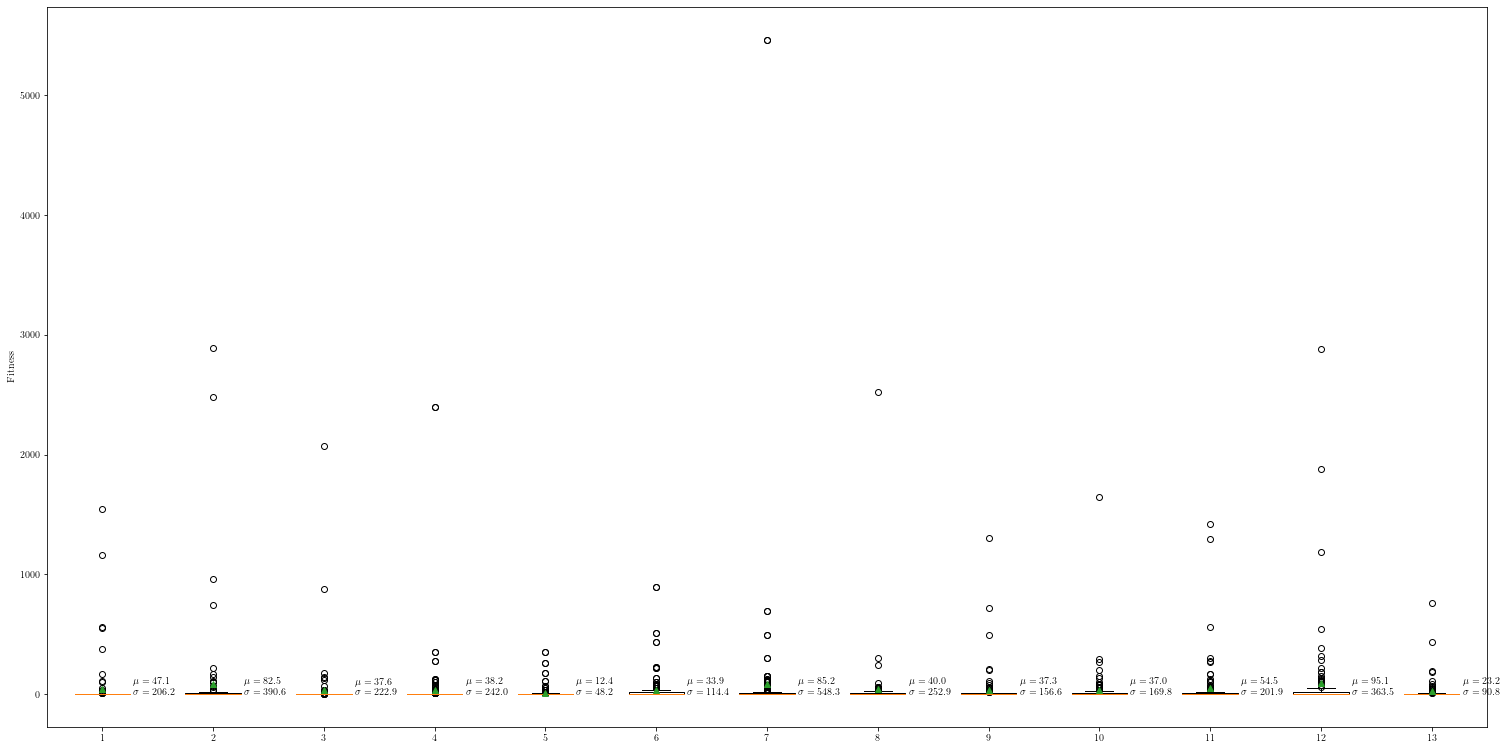

In [19]:
seqs_operators, seqs_ids, fitnesses = generate_seqs()
fig = plt.figure(figsize =(20, 10))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
def last_fitness(seqs):
  return [x[-1] for x in seqs] 
 
data = fitness_good #last_fitness(seqs) for seqs in fitness_good] + [last_fitness(fitnesses[:100])]
# Creating plot
bp = ax.boxplot(data, showmeans=True)
m1 = [np.mean(x) for x in data]
med1 = [np.median(x) for x in data]
st1 = [np.std(x) for x in data]

for i, line in enumerate(bp['medians']):
  x, y = line.get_xydata()[1]
  
  text = '\n'.join((
  r'$\mu=%.1f$' % (m1[i], ),
  #r'$\mathrm{median}=%.2f$' % (med1[i], ),
  r'$\sigma=%.1f$' % (st1[i], )))
  #print(text)
  print(x, y)
  ax.annotate(text, xy=(x+0.03, y-2.95))
#ax.set_xticklabels(['HyGpt - 1 epoch', 'HyGpt - 2 epoch', 'HyGpt - 3 epoch', 'HyGpt - 4 epoch', 'NNHH'])
fig.subplots_adjust()
fig.tight_layout()
plt.ylabel('Fitness')
# show plot
figures_folder = 'HyGpt/'
saving_format = 'png'
fig.savefig(figures_folder + 'bmhs_vs_strategies.' + saving_format, 
                    format=saving_format, bbox_inches="tight", dpi=333, transparent=True)
plt.show()